In [1]:
import pandas as pd
train_df=pd.read_csv('/content/train.csv')
test_df=pd.read_csv('/content/test.csv')

In [2]:

# 训练集处理
train_features = train_df.drop(['Id', 'SalePrice'], axis=1)
train_labels = train_df['SalePrice']

# 测试集处理
test_feature = test_df.drop(['Id'], axis=1)

# 合并特征
all_feature = pd.concat((train_features, test_feature), axis=0)


In [3]:
numeric_features=all_feature.dtypes[all_feature.dtypes!='object'].index
all_feature[numeric_features]=all_feature[numeric_features].apply(lambda x:(x-x.mean())/x.std())
all_feature[numeric_features]=all_feature[numeric_features].fillna(0)

In [4]:
all_feature=pd.get_dummies(all_feature,dummy_na=True)


In [5]:
import torch
import numpy as np
all_features = all_feature.to_numpy(dtype=np.float32)
n_train=train_df.shape[0]
train_data=torch.tensor(all_features[:n_train],dtype=torch.float32)
test_data=torch.tensor(all_features[n_train:],dtype=torch.float32)
train_label=torch.tensor(train_df.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [6]:
from torch import nn
input=train_data.shape[1]
loss=nn.MSELoss()


In [7]:
def log_loss(feature,label):
  cl=torch.clamp(net(feature),1,float('inf'))
  los=torch.sqrt(loss(torch.log(cl),torch.log(label)))
  return los.item()

In [8]:
from torch.utils.data import TensorDataset,DataLoader
from tqdm import tqdm

In [9]:
"""
法一
from sklearn.model_selection import train_test_split
# 拆分训练集和验证集
train_X, val_X, train_y, val_y = train_test_split(
    train_data, train_label, test_size=0.2, random_state=42
)

法二
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in kf.split(train_data):
    X_train_fold = train_data[train_idx]
    y_train_fold = train_label[train_idx]
    X_val_fold = train_data[val_idx]
    y_val_fold = train_label[val_idx]
    # 在这里训练和验证

"""

'\n法一\nfrom sklearn.model_selection import train_test_split\n# 拆分训练集和验证集\ntrain_X, val_X, train_y, val_y = train_test_split(\n    train_data, train_label, test_size=0.2, random_state=42\n)\n\n法二\nfrom sklearn.model_selection import KFold\nkf = KFold(n_splits=5, shuffle=True, random_state=42)\nfor train_idx, val_idx in kf.split(train_data):\n    X_train_fold = train_data[train_idx]\n    y_train_fold = train_label[train_idx]\n    X_val_fold = train_data[val_idx]\n    y_val_fold = train_label[val_idx]\n    # 在这里训练和验证\n\n'

In [29]:
device='cuda'
epoches=100
batch_size=128
train_loss=[]
test_loss=[]
net=nn.Sequential(nn.Linear(input,256),nn.ReLU(),nn.Linear(256,1))
net=net.to(device)
optimizer=torch.optim.Adam(net.parameters(),lr=1)
def train(train_feature,train_label,test_feature,test_label):



  train_set=TensorDataset(train_feature,train_label)
  train_loader=DataLoader(train_set,shuffle=True,num_workers=2,batch_size=64)
  test_set=TensorDataset(test_feature,test_label)
  test_loader=DataLoader(test_set,shuffle=True,num_workers=2,batch_size=64)
  a=len(train_loader.dataset)
  test_feature=test_feature.to(device)
  test_label=test_label.to(device)
  train_feature=train_feature.to(device)
  train_label=train_label.to(device)
  for epoch in range(epoches):
    for x,y in train_loader:
      x,y=x.to(device),y.to(device)
      l=loss(net(x),y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
    l=log_loss(train_feature,train_label)
    train_loss.append(l)
    l=log_loss(test_feature,test_label)
    test_loss.append(l)




In [11]:
print(train_data.shape[0], train_label.shape[0])


1460 1460


In [30]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=6,shuffle=True,random_state=42)
for train_idx,test_idx in kf.split(train_data):
  x_train=train_data[train_idx]
  y_train=train_label[train_idx]
  x_test=train_data[test_idx]
  y_test=train_label[test_idx]
  train(x_train,y_train,x_test,y_test)

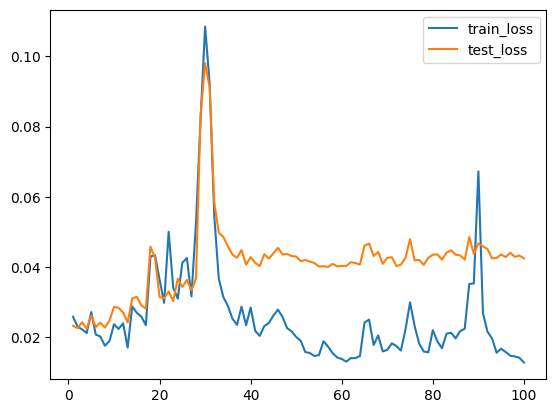

In [34]:
import matplotlib.pyplot as plt
plt.plot(range(1,epoches+1),train_loss[500:600],label='train_loss')
plt.plot(range(1,epoches+1),test_loss[500:600],label='test_loss')
plt.legend()
plt.show()

In [33]:
net.eval()
pred=net(test_data.to(device))
pred=pred.cpu().detach().numpy().reshape(-1)
test_ids=test_df['Id']
output_df=pd.DataFrame({
    'Id':test_ids,
    'SalePrice':pred
}
)
output_df.to_csv('submission.csv',index=False)
print('right')

right
